## Imports

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
import keras
import keras.backend as K
import keras_tuner as kt
from keras_tuner import Objective

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape

import numpy as np
import pandas as pd

import os
import random
import pickle
import time

import gc
import multiprocessing
import threading

from model_builder import ModelBuilder

from matplotlib import pyplot as plt

import warnings
from warnings import simplefilter

2024-05-23 10:35:38.483897: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 10:35:38.483925: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 10:35:38.490571: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-23 10:35:38.514643: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="keras")
simplefilter(action='ignore', category=FutureWarning)

#Reproducibilty
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_CUDNN_DETERMINISTIC'] = 'true'
os.environ['TF_DETERMINISTIC_OPS'] = 'true'

## Evaluation functions

Evaluation Metrics

The models will be evaluated according to the following metrics:

* Root Mean Squared Error (RMSE)
* Mean absolute percentage error (MAPE)
* Percentage Bias Error (PBE)
* Prediction of change in direction (POCID)
* Mean absolute scaled error (MASE)
* Mean absolute error (MAE)


Considering $y_i$ as the actual value of observation $i$, $\hat{y_i}$ as the predicted value, and $n$ as the number of observations (i.e., forecast horizon), the metrics are defined according to the equations:

$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y_i})^2}$

$MAPE = \frac{1}{n}\sum_{i=1}^{n}\frac{|y_i - \hat{y_i}|}{max(ϵ,|y_i|)} \times 100$

$PBE = 100\times\frac{\sum_{i=1}^{n}(y_i-\hat{y}_i)} {\sum_{i=1}^{n}y_i}$

\begin{equation}
POCID = 100 \times \frac{\sum_{i=2}^n}{n}D_i \quad \text{where:} \quad D_i =
\left\{
\begin{aligned}
1 & :  (\hat{y_i} - \hat{y}_{i-1})(y_i - y_{i-1}) > 0\\
0 & : \text{otherwise} \\
\end{aligned}
\right.
\end{equation}

$MASE = \frac{MAE}{MAE_{naive}}$

**Interpretation:** A POCID of 100 would indicate that the model always correctly predicted the change in direction of the target variable, while a POCID of 0 would indicate that the model never correctly predicted. A POCID value between 0 and 100 indicates the proportion of cases where the model correctly predicted the change in direction.

In [3]:
def rmse(y_true, y_pred):
  return np.sqrt(mse(y_true, y_pred))

def pbe(y_true, y_pred):
  return 100*(np.sum(y_true - y_pred)/np.sum(y_true))

def pocid(y_true, y_pred):
    n = len(y_true)
    D = [1 if (y_pred[i] - y_pred[i-1]) * (y_true[i] - y_true[i-1]) > 0 else 0 for i in range(1, n)]
    POCID = 100 * np.sum(D) / n
    return POCID

def mase(y_true, y_pred, y_baseline):
    mae_pred = np.mean(np.abs(y_true - y_pred))
    mae_naive = np.mean(np.abs(y_true - y_baseline))
    result = mae_pred/mae_naive
    return result

## Normalization

MinMaxScaler

## Generation of the attribute-value table

Machine learning algorithms receive data in attribute-value format as input, which is a set of features (x) where the last column (y) is the target. In our case, the target will be the future value of the series.

The construction of this table involves the process of a rolling window, where a data window of length *l* traverses the entire series extracting the observations that will be the features and the future value that will be the target, as illustrated. At each step, the window is shifted by 1 observation. In the image, *h* represents the forecasting horizon. In the example, the model will predict the next 4 observations of the series.

**Attention:** Note that in the code below, each subsequence is normalized, including the target.

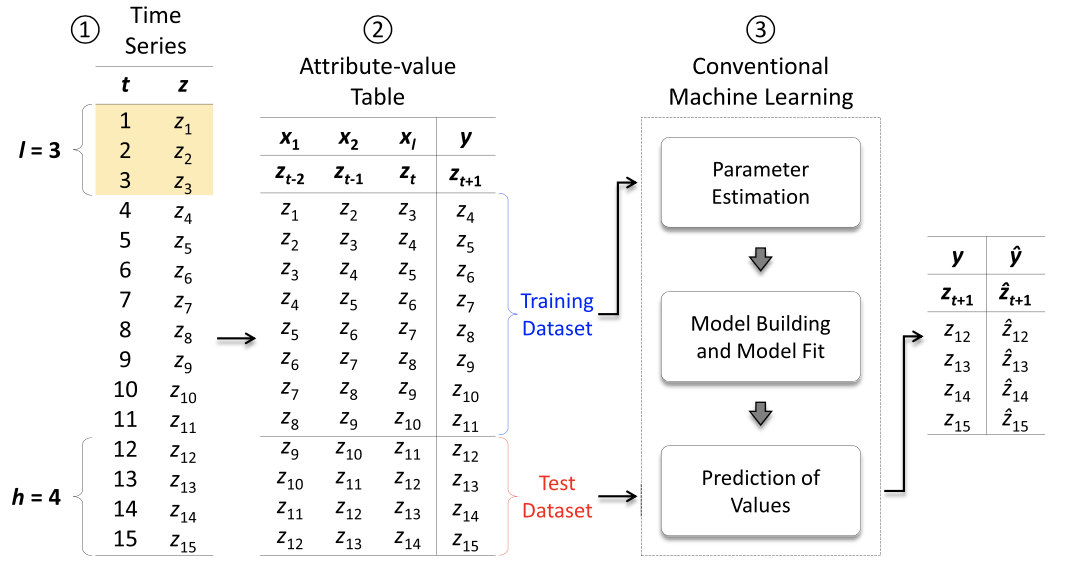

In [5]:
# In general, a window size capable of capturing a cycle of the data is considered
# For example, 12 observations in the case of data with monthly frequency
def rolling_window(series, window):
  data = []
  
  # Normalizing data to the range [-1, 1] using MinMaxScaler
  scaler = MinMaxScaler(feature_range=(-1, 1))

  for i in range(len(series)-window):
    example = np.array(series[i:i + window + 1])
    example = scaler.fit_transform(example.reshape(-1, 1)).flatten()
    data.append(example)
    
  df = pd.DataFrame(data)
  return df, scaler

## Division of data into training and testing subsets (holdout validation)

In [6]:
# For sales prediction by state (monthly), horizon = 12 will be considered
# For sales prediction by municipality (annual), horizon = 1 will be considered
def train_test_split_window(data, horizon):
  X = data.iloc[:, :-1] # features
  y = data.iloc[:, -1] # target

  X_train = X[:-horizon] # features train
  X_test =  X[-horizon:] # features test

  y_train = y[:-horizon] # target train
  y_test = y[-horizon:] # target test
  return X_train, X_test, y_train, y_test

## Recursive multi-step forecasting

In [7]:
def recursive_multistep_forecasting(X_test, model, horizon):
  # The example consists of the last observed values seen
  # In practice, it is the first example from the test set
  example = X_test.iloc[0].values.reshape(1,-1)

  preds = []
  for i in range(horizon):
    pred = model.predict(example)[0]
    preds.append(pred)

    # Discard the value from the first position of the feature vector
    example = example[:,1:]

    # Add the predicted value to the last position of the feature vector
    example = np.append(example, pred)
    example = example.reshape(1,-1)
  return preds

## Function to convert the date format

In [8]:
def convert_date(date_string):
    year_month = date_string.strip()
    year = int(year_month[:4])
    month = int(year_month[4:])
    return pd.Timestamp(year=year, month=month, day=1)

## Function LSTM

In [9]:
def rescaled_predicted_values(horizon, data, predictions, scaler, show_plot=None):
    """
    Rescaling the predicted values to the original scale.

    Parameters:
        - horizon: int, prediction horizon.
        - data: DataFrame, containing the time series data used for normalization.
        - scaler: Scaler object, scaler used for normalization.
        - predictions: array-like, containing the normalized predicted values.
        - show_plot: bool or None, whether to display a plot of the forecasted values.

    Returns:
        - rmse_rescaled (float): Rescaled Root Mean Squared Error.
        - mape_rescaled (float): Rescaled Mean Absolute Percentage Error.
        - pbe_rescaled (float): Rescaled Prediction Bias Error.
        - pocid_rescaled (float): Rescaled Percentage of Correct Indication Direction.
        - mase_rescaled (float): Rescaled Mean Absolute Scaled Error.
        - mae_rescaled (float): Rescaled Mean Absolute Error.

    """
    
    # Inverse MinMax
    mat_predictions = np.zeros((len(predictions), 13)) 
    
    for i, pred in enumerate(predictions):
        mat_predictions[i, -1] = pred
        
    predictions_rescaled = scaler.inverse_transform(mat_predictions)[:, 12]

    # Retrieves the actual values in the original scale
    y_test_rescaled = data["m3"][-horizon:].values
    
    # Calculation of evaluation metrics
    rmse_result_rescaled = rmse(y_test_rescaled, predictions_rescaled)
    mape_result_rescaled = mape(y_test_rescaled, predictions_rescaled)
    pbe_result_rescaled = pbe(y_test_rescaled, predictions_rescaled)
    pocid_result_rescaled  = pocid(y_test_rescaled, predictions_rescaled)
    mae_result_rescaled = mean_absolute_error(y_test_rescaled, predictions_rescaled)
    y_baseline = data["m3"][-horizon*2:-horizon].values
    mase_result_rescaled = mase(y_test_rescaled, predictions_rescaled, y_baseline)

    if show_plot:
        # Plot of the rescaled predictions
        plt.figure(figsize=(8, 2))
        plt.title('Predictions in original scale')
        plt.plot(y_test_rescaled, label='Actual')
        plt.plot(predictions_rescaled, linewidth=5, alpha=0.4, label='Predicted')
        plt.plot(y_baseline, label='Baseline')
        plt.scatter(range(len(y_test_rescaled)), y_test_rescaled, color='blue')
        plt.scatter(range(len(predictions_rescaled)), predictions_rescaled, color='red')
        plt.scatter(range(len(y_baseline)), y_baseline, color='green')
        plt.legend()
        plt.show()


    return rmse_result_rescaled, mape_result_rescaled, pbe_result_rescaled, pocid_result_rescaled, mase_result_rescaled, mae_result_rescaled

In [10]:
def run_lstm_model(horizon, window, data, epochs, state, product, rescaling=None, show_plot=None, verbose=2, return_model=None):
    """
    Run LSTM model for time series forecasting.

    Parameters:
        - horizon (int): Prediction horizon.
        - window (int): Length of the window for attribute-value table generation.
        - data (pd.DataFrame): DataFrame containing the time series data.
        - epochs (int): Number of epochs for training the LSTM model.
        - state: The specific state for the model (description needed based on context).
        - product: The specific product for the model (description needed based on context).
        - rescaling (bool or None, optional): Whether to rescale the predicted values to the original scale. Default is None.
        - show_plot (bool or None, optional): Whether to display a plot of the forecasted values. Default is None.
        - verbose (int, optional): Controls the verbosity of the training process. 0 = silent, 1 = progress bar, 2 = one line per epoch. Default is 2.
        - return_model (bool or None, optional): Whether to return the trained model. Default is None.
        
    Returns:
        - rmse (float): Root Mean Squared Error.
        - mape (float): Mean Absolute Percentage Error.
        - pbe (float): Prediction Bias Error.
        - pocid (float): Percentage of Correct Indication Direction.
        - mae (float): Mean Absolute Error.
        
        If rescaling is True, also returns rescaled metrics:
          - rmse_rescaled (float): Rescaled Root Mean Squared Error.
          - mape_rescaled (float): Rescaled Mean Absolute Percentage Error.
          - pbe_rescaled (float): Rescaled Prediction Bias Error.
          - pocid_rescaled (float): Rescaled Percentage of Correct Indication Direction.
          - mase_rescaled (float): Rescaled Mean Absolute Scaled Error.
          - mae_rescaled (float): Rescaled Mean Absolute Error.

    """

    # Generating the attribute-value table (normalized)
    data_normalized, scaler = rolling_window(data["m3"], window)

    # Splitting the data into train/test considering a prediction horizon of 12 months
    X_train, X_test, y_train, y_test = train_test_split_window(data_normalized, horizon)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
    
    # Define Early Stopping
    early_stopping = EarlyStopping(monitor='root_mean_squared_error', patience=8, mode='min', verbose= 1)

    ''' 
    Keras Tuner:
        - GridSearch 
            - max_trials=300
            
        - Hyperband
            - factor: Integer, the reduction factor for the number of epochs and number of models for each bracket. Defaults to 3.
            - max_epochs: Integer, the maximum number of epochs to train one model. It is recommended to set this to a value slightly higher than the expected epochs to 
            convergence for your largest Model, and to use early stopping during training (for example, via tf.keras.callbacks.EarlyStopping). Defaults to 100.
            
        - RandomSearch
            - max_trials=300

    '''
    num_trials= 200
    
    tuner = kt.RandomSearch(
        hypermodel=ModelBuilder(),
        objective=Objective('root_mean_squared_error', direction='min'),
        max_trials= num_trials,
        max_retries_per_trial= 0,
        max_consecutive_failed_trials= 1,
        seed=42,
        directory='tuner',
        project_name=f'lstm_{state}_{product}',
        executions_per_trial=1
    )
    
    try:
        tuner.search(X_train, y_train, epochs=epochs, 
                                batch_size = 32, validation_data=(X_val, y_val), 
                                verbose=verbose, callbacks=[early_stopping])

        for trial in kt.tuner.oracle.get_best_trials(num_trials=num_trials):
            model = kt.tuner.hypermodel.build(trial.hyperparameters)
        
            del model

    except Exception as e:
        print("An error occurred:", e)
        
    # Get the best model
    best_model = tuner.get_best_models(num_models=1)[0]
    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0].values
    
    # Training the model
    model = tuner.hypermodel.build(best_model)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val), verbose=verbose, callbacks=[early_stopping])
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    gc.collect() 
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    del tuner
    
    # Predicting
    predictions = recursive_multistep_forecasting(X_test, best_model, horizon)    

    # Calculating evaluation metrics
    rmse_result = rmse(y_test.values, predictions)
    mape_result = mape(y_test.values, predictions)
    pbe_result = pbe(y_test.values, predictions)
    pocid_result = pocid(y_test.values, predictions)
    mae_result = mean_absolute_error(y_test.values, predictions)
    
    if show_plot:
        
        plt.figure(figsize=(8, 6))
        plt.plot(train_loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Learning Curve')
        plt.legend()
        plt.show()
        
        # Plotting normalized predictions
        plt.figure(figsize=(8, 2))
        plt.title('Normalized Predictions')
        plt.plot(y_test.values, label='Actual')
        plt.plot(predictions, linewidth=5, alpha=0.4, label='Predicted')
        plt.scatter(range(len(y_test)), y_test.values, color='blue')
        plt.scatter(range(len(predictions)), predictions, color='red')
        plt.legend()
        plt.show()

        plt.figure(figsize=(3,3))
        plt.scatter(y_test.values, predictions, alpha=0.4)
        plt.axline((0, 0), slope=1, linestyle='dotted', color='gray')
        plt.xlabel('Actual values')
        plt.ylabel('Predicted values')
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
    
    if rescaling:
        if return_model:
            rmse_result_rescaled, mape_result_rescaled, pbe_result_rescaled, pocid_result_rescaled, mase_result_rescaled, mae_result_rescaled = rescaled_predicted_values(horizon= horizon, data= data, predictions= predictions, scaler= scaler, show_plot=show_plot)
            return best_model, rmse_result, mape_result, pbe_result, pocid_result, mae_result, best_hyperparameters, rmse_result_rescaled, mape_result_rescaled, pbe_result_rescaled, pocid_result_rescaled, mase_result_rescaled, mae_result_rescaled
        else:
            rmse_result_rescaled, mape_result_rescaled, pbe_result_rescaled, pocid_result_rescaled, mase_result_rescaled, mae_result_rescaled = rescaled_predicted_values(horizon= horizon, data= data, predictions= predictions, scaler= scaler, show_plot=show_plot)
        return rmse_result, mape_result, pbe_result, pocid_result, mae_result, best_hyperparameters, rmse_result_rescaled, mape_result_rescaled, pbe_result_rescaled, pocid_result_rescaled, mase_result_rescaled, mae_result_rescaled
    else:
        if return_model:
            return best_model, rmse_result, mape_result, pbe_result, pocid_result, mae_result, best_hyperparameters
        else:
            return rmse_result, mape_result, pbe_result, pocid_result, mae_result, best_hyperparameters    

In [11]:
def create_thread_simple_train():    
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)
    os.environ['PYTHONHASHSEED'] = str(42)
    tf.keras.utils.set_random_seed(42)
    
    print(tf.config.list_physical_devices('GPU'))
    
    # load database test
    data_filtered_test = pd.read_csv("../database/venda_process/mensal/uf/glp/mensal_pr_glp.csv", sep=";",  parse_dates=['timestamp'], date_parser=convert_date)

    print(" ========== Starting univariate test for the state of Paraná - GLP ==========")

    start_timestamp = time.strftime("%Y-%m-%d %H:%M:%S")
    print(f"\nExecution started at: {start_timestamp}")
    start_time = time.time()

    # Running the LSTM model
    rmse_result, mape_result, pbe_result, pocid_result, mae_result, best_param, rmse_result_rescaled, mape_result_rescaled, pbe_result_rescaled, pocid_result_rescaled, mase_result_rescaled, mae_result_rescaled = \
    run_lstm_model(horizon=12, window=12, data=data_filtered_test, epochs=200, state="pr", product="glp", rescaling=True, show_plot=True, verbose=1)

    end_time = time.time()
    execution_time = end_time - start_time

    print(f"Function execution time: {execution_time:.2f} seconds")
    print(f"Execution ended at: {time.strftime('%Y-%m-%d %H:%M:%S')}")

    # Results without scaling
    print("\nResults without scaling:")
    print(f'RMSE: {rmse_result}')
    print(f'MAPE: {mape_result}')
    print(f'PBE: {pbe_result}')
    print(f'POCID: {pocid_result}')
    print(f'MAE: {mae_result}')

    # Rescaled results
    print("\nRescaled results:")
    print(f'Rescaled RMSE: {rmse_result_rescaled}')
    print(f'Rescaled MAPE: {mape_result_rescaled}')
    print(f'Rescaled PBE: {pbe_result_rescaled}')
    print(f'Rescaled POCID: {pocid_result_rescaled}')
    print(f'Rescaled MAE: {mae_result_rescaled}')
    print(f'Rescaled MASE: {mase_result_rescaled}')

    # Display the results
    print("\nBest parameters found: ", best_param)

## Looping through all states and products

In [12]:
all_data = pd.read_csv("../database/combined_data.csv", sep=";")

In [13]:
# Initialize the dictionary
state_product_dict = {}

# Iterate over unique states
for state in all_data['state'].unique():
    # Filter products corresponding to this state
    products = all_data[all_data['state'] == state]['product'].unique()
    # Add to the dictionary
    state_product_dict[state] = list(products)

In [14]:
def run_lstm_in_thread(state, product, horizon, window, data_filtered, epochs, verbose, save_model, results_df, lock):
    try:
        # Rodar o modelo LSTM
        model, rmse_result, mape_result, pbe_result, pocid_result, mae_result, best_hyperparameters, rmse_result_rescaled, mape_result_rescaled, pbe_result_rescaled, pocid_result_rescaled, mase_result_rescaled, mae_result_rescaled = \
        run_lstm_model(horizon=horizon, window=window, data=data_filtered, epochs=epochs, state=state, product=product, rescaling=True, show_plot=False, verbose=verbose, return_model=True)

        # Salvar modelo
        if save_model and model is not None:
            directory = "saved_models"
            if not os.path.exists(directory):
                os.makedirs(directory)

            state_directory = os.path.join(directory, state)
            if not os.path.exists(state_directory):
                os.makedirs(state_directory)

            model_name = f"lstm_{state}_{product}"
            model_path = os.path.join(state_directory, f"{model_name}.pkl")
            with open(model_path, 'wb') as f:
                pickle.dump(model, f)

        with lock:
            results_df = pd.concat([results_df, pd.DataFrame({'HORIZON': horizon,
                                                              'WINDOW': window,
                                                              'EPOCHS': epochs,
                                                              'BEST_PARAM': str(best_hyperparameters),
                                                              'VAL_DROPOUT': best_hyperparameters['val_dropout'],
                                                              'NUM1_LSTM': best_hyperparameters['num1_lstm'],
                                                              'NUM2_LSTM': best_hyperparameters['num2_lstm'],
                                                              'OPTIMIZER': best_hyperparameters['optimizer'],
                                                              'ACTIVATION': best_hyperparameters['activation'],
                                                              "ACTIVATION_DENSE": best_hyperparameters['activation_dense'],
                                                              'STATE': state,
                                                              'PRODUCT': product,
                                                              'RMSE': rmse_result,
                                                              'MAPE': mape_result,
                                                              'PBE': pbe_result,
                                                              'POCID': pocid_result,
                                                              'MAE': mae_result,
                                                              'RMSE_RESCALED': rmse_result_rescaled,
                                                              'MAPE_RESCALED': mape_result_rescaled,
                                                              'PBE_RESCALED': pbe_result_rescaled,
                                                              'POCID_RESCALED': pocid_result_rescaled,
                                                              'MAE_RESCALED': mae_result_rescaled,
                                                              'MASE_RESCALED': mase_result_rescaled,
                                                              'ERROR': np.nan}, index=[0])], ignore_index=True)

    except Exception as e:
        print(f"An error occurred for product '{product}' in state '{state}': {e}")
        with lock:
            results_df = pd.concat([results_df, pd.DataFrame({'HORIZON': np.nan,
                                                              'WINDOW': np.nan,
                                                              'EPOCHS': np.nan,
                                                              'BEST_PARAM': np.nan,
                                                              'VAL_DROPOUT': np.nan,
                                                              'NUM1_LSTM': np.nan,
                                                              'NUM2_LSTM': np.nan,
                                                              'OPTIMIZER': np.nan,
                                                              'ACTIVATION': np.nan,
                                                              "ACTIVATION_DENSE": np.nan,
                                                              'STATE': state,
                                                              'PRODUCT': product,
                                                              'RMSE': np.nan,
                                                              'MAPE': np.nan,
                                                              'PBE': np.nan,
                                                              'POCID': np.nan,
                                                              'MAE': np.nan,
                                                              'RMSE_RESCALED': np.nan,
                                                              'MAPE_RESCALED': np.nan,
                                                              'PBE_RESCALED': np.nan,
                                                              'POCID_RESCALED': np.nan,
                                                              'MAE_RESCALED': np.nan,
                                                              'MASE_RESCALED': np.nan,
                                                              'ERROR': f"An error occurred for product '{product}' in state '{state}': {e}"}, index=[0])], ignore_index=True)

In [15]:
def loop_lstm(horizon, window, epochs, verbose, bool_save, save_model=None):
    """
    Loop through LSTM model with different configurations.

    Parameters:
        - horizon: int, prediction horizon.
        - window: int, length of the window for attribute-value table generation.
        - epochs: int, number of epochs for training the LSTM model.
        - verbose: int, controls the verbosity of the training process. 0 = silent, 1 = progress bar, 2 = one line per epoch.
        - bool_save: bool, flag indicating whether to save the trained models.
        - save_model: bool, save models.

    Returns:
        None
    """
    
    results_df = pd.DataFrame(columns=["HORIZON", "WINDOW", "EPOCHS", "BEST_PARAM", "VAL_DROPOUT", "NUM1_LSTM", "NUM2_LSTM", "OPTIMIZER", "ACTIVATION", "ACTIVATION_DENSE", "STATE", "PRODUCT", "RMSE", "MAPE", "PBE", "POCID", "MAE", "RMSE_RESCALED", "MAPE_RESCALED", "PBE_RESCALED", "POCID_RESCALED", "MAE_RESCALED", "MASE_RESCALED", "ERROR"])
    semaphore = threading.Semaphore(1)

    for state, products in state_product_dict.items():
        for product in products:
            print(f"========== State: {state}, product: {product} ==========")

            start_timestamp = time.strftime("%Y-%m-%d %H:%M:%S")
            print(f"\nExecution started at: {start_timestamp}")
            start_time = time.time()

            random.seed(42)
            np.random.seed(42)
            tf.random.set_seed(42)
            os.environ['PYTHONHASHSEED'] = str(42)
            keras.utils.set_random_seed(42)

            # Filtrar os dados
            data_filtered = all_data[(all_data['state'] == state) & (all_data['product'] == product)]

            thread = multiprocessing.Process(target=run_lstm_in_thread, args=(state, product, horizon, window, data_filtered, epochs, verbose, save_model, results_df, semaphore))
            thread.start()
            thread.join()
    
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"Function execution time: {execution_time:.2f} seconds")
            print(f"Execution ended at: {time.strftime('%Y-%m-%d %H:%M:%S')}")

    if bool_save:
        directory = 'result'
        if not os.path.exists(directory):
            os.makedirs(directory)

        file_path = os.path.join(directory, 'lstm_results.xlsx')
        if os.path.exists(file_path):
            existing_df = pd.read_excel(file_path)
        else:
            existing_df = pd.DataFrame()

        combined_df = pd.concat([existing_df, results_df], ignore_index=True)
        combined_df.to_excel(file_path, index=False)

In [16]:
if __name__ == "__main__":
    try:
        
        # Test Univariate - PR GLP
        thread = multiprocessing.Process(target=create_thread_simple_train)
        thread.start()
        thread.join()
    
        # LOOP LSTM ALL STATES AND PRODUCT
        # loop_lstm(horizon=12, window=12, epochs=200, verbose= 1, bool_save=True, save_model=True)
    except Exception as e:
        print("An error occurred:", e)

Trial 154 Complete [00h 00m 22s]
root_mean_squared_error: 0.3664706349372864

Best root_mean_squared_error So Far: 0.2964704632759094
Total elapsed time: 00h 49m 43s

Search: Running Trial #155

Value             |Best Value So Far |Hyperparameter
0.08              |0.02              |val_dropout
12                |24                |num1_lstm
6                 |6                 |num2_lstm
rmsprop           |nadam             |optimizer
mish              |mish              |activation
elu               |elu               |activation_dense

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 601ms/step - loss: 0.3305 - mean_squared_error: 0.3305 - root_mean_squared_error: 0.5749 - val_loss: 0.3692 - val_mean_squared_error: 0.3692 - val_root_mean_squared_error: 0.6076
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.3288 - mean_squared_error: 0.3288 - root_mean_squared_error: 0.5734 - val_loss: 0.3647 - val_mean_squared_error: 0.3647 - val_root_mean_squared_error: 0.6039
Epoch 3/200